In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [20]:
# Load the dataset
data = pd.read_csv("/Users/shamiksinha/Desktop/ML assignment/code_2022468/HeartDisease.csv")

# Fill missing values....... fill with mean median mode depending on data type

# For numerical columns
numerical_cols = ['totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'cigsPerDay', 'age']
data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].median())

# For categorical columns
categorical_cols = ['male', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']
data[categorical_cols] = data[categorical_cols].fillna(data[categorical_cols].mode().iloc[0])


# Determine the split indices according to the requirements
total_rows = len(data)
train_end = int(total_rows * 0.7)
val_end = int(total_rows * 0.85)

# Split the dataset
train_data = data.iloc[:train_end]
val_data = data.iloc[train_end:val_end]
test_data = data.iloc[val_end:]

# Separate features and target variable if you have one (uncomment and adjust if needed)
X_train = train_data.drop('HeartDisease', axis=1)
Y_train = train_data['HeartDisease']

X_val = val_data.drop('HeartDisease', axis=1)
Y_val = val_data['HeartDisease']

X_test = test_data.drop('HeartDisease', axis=1)
Y_test = test_data['HeartDisease']

# Check the sizes
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 2966
Validation set size: 636
Test set size: 636


In [4]:
#converting the pandas dataframe to numpy array

X_train = X_train.values
Y_train = Y_train.values

X_test = X_test.values
Y_test = Y_test.values

X_val = X_val.values
Y_val = Y_val.values


In [5]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [6]:
def accuracy(predictions, groundTruth):
  return np.mean(predictions == groundTruth)* 100

In [7]:
class LogisticRegression():
    def __init__(self, learningRate, epochs, regularization='none', lambda_=0.1, patience=100, tolerance=1e-3):
        self.learningRate = learningRate
        self.epochs = epochs
        self.regularization = regularization
        self.lambda_ = lambda_
        self.patience = patience
        self.tolerance = tolerance
        self.weights = None
        self.bias = None
        self.costList = None
        self.accuracyList = None
        self.valCostList = None
        self.valAccList = None

    def getValCost(self):
      return self.valCostList

    def getValAcc(self):
      return self.valAccList

    def getLoss(self):
        return self.costList

    def getAccuracy(self):
        return self.accuracyList

    def getValAcc(self):
        return []

    def gradientDescent(self, X, Y, earlyStopping=True):
        m, n = X.shape
        self.weights = np.ones(n) #initialising the weights as 1s
        self.bias = 1 #initialising the bias as one

        self.costList = []
        self.accuracyList = []
        self.valCostList = []
        self.valAccList = []

        epsilon = 1e-10  # Small constant to prevent log(0)

        bestLoss = float('inf')
        patienceCounter = 0

        for epoch in range(self.epochs):
            hypothesis = np.dot(X, self.weights) + self.bias
            yPrediction = sigmoid(hypothesis)

            # Cost function (cross-entropy loss) with regularization
            if self.regularization == 'l1':
                cost = -(1/m) * np.sum(Y * np.log(yPrediction + epsilon) + (1 - Y) * np.log(1 - yPrediction + epsilon)) + self.lambda_ * np.sum(np.abs(self.weights))
            elif self.regularization == 'l2':
                cost = -(1/m) * np.sum(Y * np.log(yPrediction + epsilon) + (1 - Y) * np.log(1 - yPrediction + epsilon)) + (self.lambda_ / 2) * np.sum(self.weights ** 2)
            else:
                cost = -(1/m) * np.sum(Y * np.log(yPrediction + epsilon) + (1 - Y) * np.log(1 - yPrediction + epsilon))

            # Accuracy
            classification = [0 if y <= 0.5 else 1 for y in yPrediction]
            acc = accuracy(classification, Y)

            self.costList.append(cost)
            self.accuracyList.append(acc)

            #validation
            modelPredictions_val = self.classify(X_val)
            valacc = accuracy(modelPredictions_val, Y_val)
            self.valAccList.append(valacc)
            hypothesis = np.dot(X_val, self.weights) + self.bias
            Y_prediction1 = sigmoid(hypothesis)
            valcost = -(1/m) * np.sum(Y_val * np.log(Y_prediction1 + epsilon) + (1 - Y_val) * np.log(1 - Y_prediction1 + epsilon))
            self.valCostList.append(valcost)


            # Gradients with regularization
            if self.regularization == 'l1':
                dw = (1/m) * np.dot(X.T, (yPrediction - Y)) + self.lambda_ * np.sign(self.weights)
            elif self.regularization == 'l2':
                dw = (1/m) * np.dot(X.T, (yPrediction - Y)) + self.lambda_ * self.weights
            else:
                dw = (1/m) * np.dot(X.T, (yPrediction - Y))

            db = (1/m) * np.sum(yPrediction - Y)

            # Update weights and bias
            self.weights = self.weights - self.learningRate * dw
            self.bias = self.bias - self.learningRate * db

            # Print progress every 100 iterations
            if epoch % (self.epochs // 10) == 0:  # Print cost every 10% of iterations
                print(f"Cost after {epoch} iterations: {cost} & accuracy : {acc}")
                # print(len(self.valAccList))

            # Early Stopping Logic
            if earlyStopping:
                if cost < bestLoss - self.tolerance:
                    bestLoss = cost
                    patienceCounter = 0  # Reset patience counter
                else:
                    patienceCounter += 1
                    if patienceCounter >= self.patience:
                        print(f"Early stopping triggered at epoch {epoch} with loss {bestLoss:.4f}")
                        break

    def classify(self, X, threshold=0.5):
        hypothesis = np.dot(X, self.weights) + self.bias
        yPrediction = sigmoid(hypothesis)
        classLabels = [0 if y <= threshold else 1 for y in yPrediction]
        return classLabels


In [21]:
#comparing the cases for early stopping and not early stopping
model = LogisticRegression(learningRate=0.0001, epochs=50000)

earlyStopping = False

#training the model on training data
model.gradientDescent(X_train, Y_train, earlyStopping)
trainingLoss = model.costList

#testing the model on training data
trainingAcc = model.accuracyList

#storing predictions for the training data
modelPredictions_train = model.classify(X_train)

print("-----------####------####------####-------------")

validationLoss = model.getValCost()

#testing the model on validation data
validationAcc = model.getValAcc()

#storing predictions for the validation data
modelPredictions_val = model.classify(X_val)

print(f"Training accuracy before early stopping: {accuracy(modelPredictions_train, Y_train)}")

print(f"Validation accuracy before early stopping: {accuracy(modelPredictions_val, Y_val)}")


print("-----------####------####------####-------------")
model1 = LogisticRegression(learningRate=0.0001, epochs=50000)

earlyStopping = True

#training the model on training data
model1.gradientDescent(X_train, Y_train, earlyStopping)
trainingLoss1 = model1.costList

#testing the model on training data
trainingAcc1 = model1.accuracyList

#storing predictions for the training data
modelPredictions_train1 = model1.classify(X_train)

print("-----------####------####------####-------------")

validationLoss1 = model1.getValCost()

#testing the model on validation data
validationAcc1 = model1.getValAcc()

#storing predictions for the validation data
modelPredictions_val1 = model1.classify(X_val)
print(f"Training accuracy after early stopping: {accuracy(modelPredictions_train1, Y_train)}")

print(f"Validation accuracy after early stopping: {accuracy(modelPredictions_val1, Y_val)}")

Cost after 0 iterations: 19.493564290301745 & accuracy : 15.340525960890089


KeyboardInterrupt: 

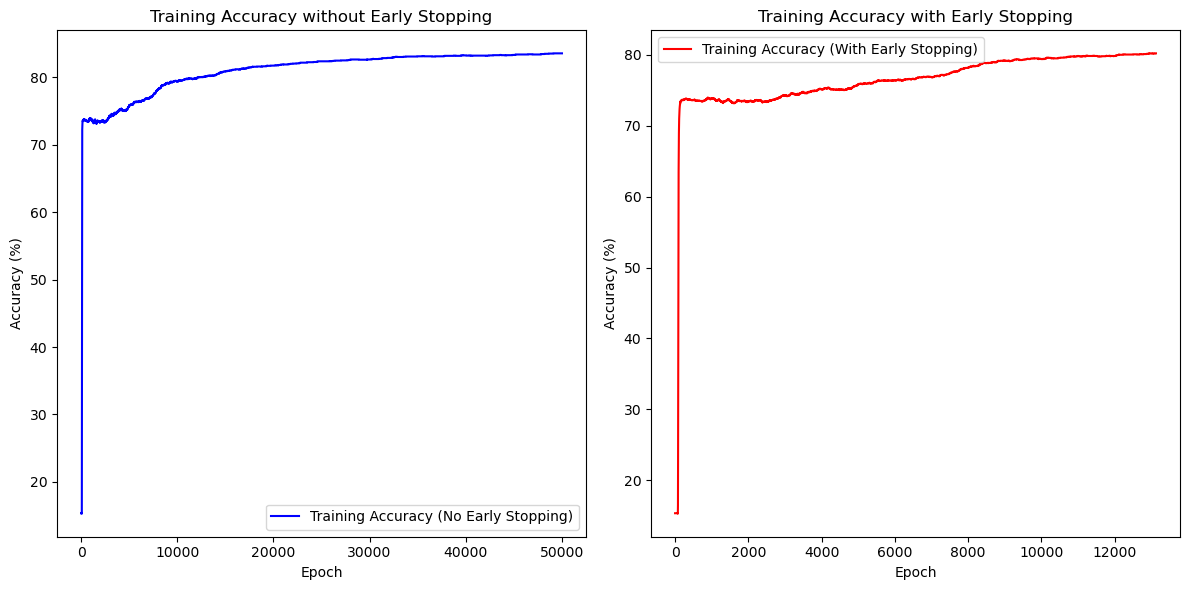

In [13]:
# Plot for training accuracy
plt.figure(figsize=(12, 6))

# Plot training accuracy for model without early stopping
plt.subplot(1, 2, 1)
plt.plot(range(len(trainingAcc)), trainingAcc, color='blue', label='Training Accuracy (No Early Stopping)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy without Early Stopping')
plt.legend()

# Plot training accuracy for model with early stopping
plt.subplot(1, 2, 2)
plt.plot(range(len(trainingAcc1)), trainingAcc1, color='red', label='Training Accuracy (With Early Stopping)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy with Early Stopping')
plt.legend()

plt.tight_layout()
plt.show()

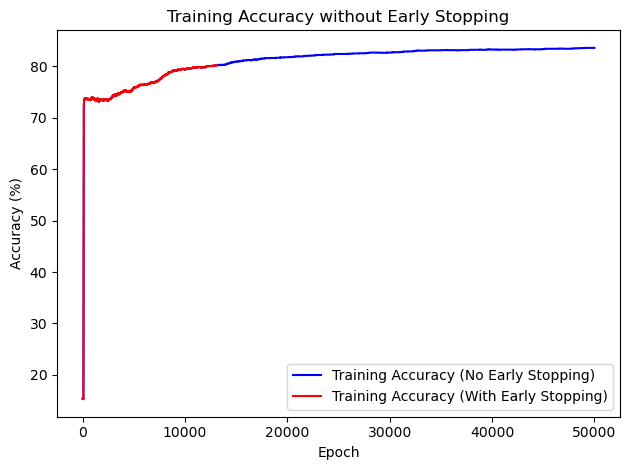

In [12]:
plt.plot(range(len(trainingAcc)), trainingAcc, color='blue', label='Training Accuracy (No Early Stopping)')
plt.plot(range(len(trainingAcc1)), trainingAcc1, color='red', label='Training Accuracy (With Early Stopping)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy without Early Stopping')
plt.legend()

plt.tight_layout()
plt.show()

**regularization**

In [26]:
learningRate = 0.0001
epochs = 50000

In [27]:
#earlyStopping
#no regularisation
model = LogisticRegression(learningRate, epochs, regularization='none')

earlyStopping = True

#training the model on training data
model.gradientDescent(X_train, Y_train, earlyStopping)
trainingLoss = model.costList

#testing the model on training data
trainingAcc = model.accuracyList

#storing predictions for the training data
modelPredictions_train = model.classify(X_train)

print("-----------####------####------####-------------")

validationLoss = model.getValCost()

#testing the model on validation data
validationAcc = model.valAccList

#storing predictions for the validation data
modelPredictions_val = model.classify(X_val)

print(f"Validation accuracy after early stopping without l1: {accuracy(modelPredictions_val, Y_val)}")

print()
print("-----------####------####------####-------------")
print("-----------####------####------####-------------")
print()
#earlyStopping
#l1 regularisation
model1 = LogisticRegression(learningRate, epochs, regularization='l1')

earlyStopping = True

#training the model on training data
model1.gradientDescent(X_train, Y_train, earlyStopping)
trainingLoss1 = model1.costList

#testing the model on training data
trainingAcc1 = model1.accuracyList

#storing predictions for the training data
modelPredictions_train1 = model1.classify(X_train)

print("-----------####------####------####-------------")

validationLoss1 = model1.getValCost()

#testing the model on validation data
validationAcc1 = model1.valAccList

#storing predictions for the validation data
modelPredictions_val1 = model1.classify(X_val)

print(f"Validation accuracy after early stopping with l1: {accuracy(modelPredictions_val1, Y_val)}")

print()
print("-----------####------####------####-------------")
print("-----------####------####------####-------------")
print()
#earlyStopping
#l2 regularisation
model2 = LogisticRegression(learningRate, epochs, regularization='l2')

earlyStopping = True

#training the model on training data
model2.gradientDescent(X_train, Y_train, earlyStopping)
trainingLoss2 = model2.costList

#testing the model on training data
trainingAcc2 = model2.accuracyList

#storing predictions for the training data
modelPredictions_train2 = model2.classify(X_train)

print("-----------####------####------####-------------")

validationLoss2 = model2.getValCost()

#testing the model on validation data
validationAcc2 = model2.valAccList

#storing predictions for the validation data
modelPredictions_val2 = model2.classify(X_val)

print(f"Validation accuracy after early stopping with l2: {accuracy(modelPredictions_val2, Y_val)}")

Cost after 0 iterations: 19.493564290301745 & accuracy : 15.340525960890089
Cost after 5000 iterations: 1.0275486481798 & accuracy : 75.85974376264329
Cost after 10000 iterations: 0.5746220654935926 & accuracy : 79.39986513823331
Early stopping triggered at epoch 13130 with loss 0.5253
-----------####------####------####-------------
Validation accuracy after early stopping without l1: 81.13207547169812

-----------####------####------####-------------
-----------####------####------####-------------

Cost after 0 iterations: 20.993564290301745 & accuracy : 15.340525960890089
Cost after 5000 iterations: 1.6661331976573912 & accuracy : 76.12946729602157
Cost after 10000 iterations: 1.1716053330271332 & accuracy : 80.17532029669589
Cost after 15000 iterations: 1.0606522075682487 & accuracy : 82.36682400539446
Cost after 20000 iterations: 1.0032819197746359 & accuracy : 83.0074173971679
Cost after 25000 iterations: 0.9494520019303625 & accuracy : 83.68172623061362
Early stopping triggered

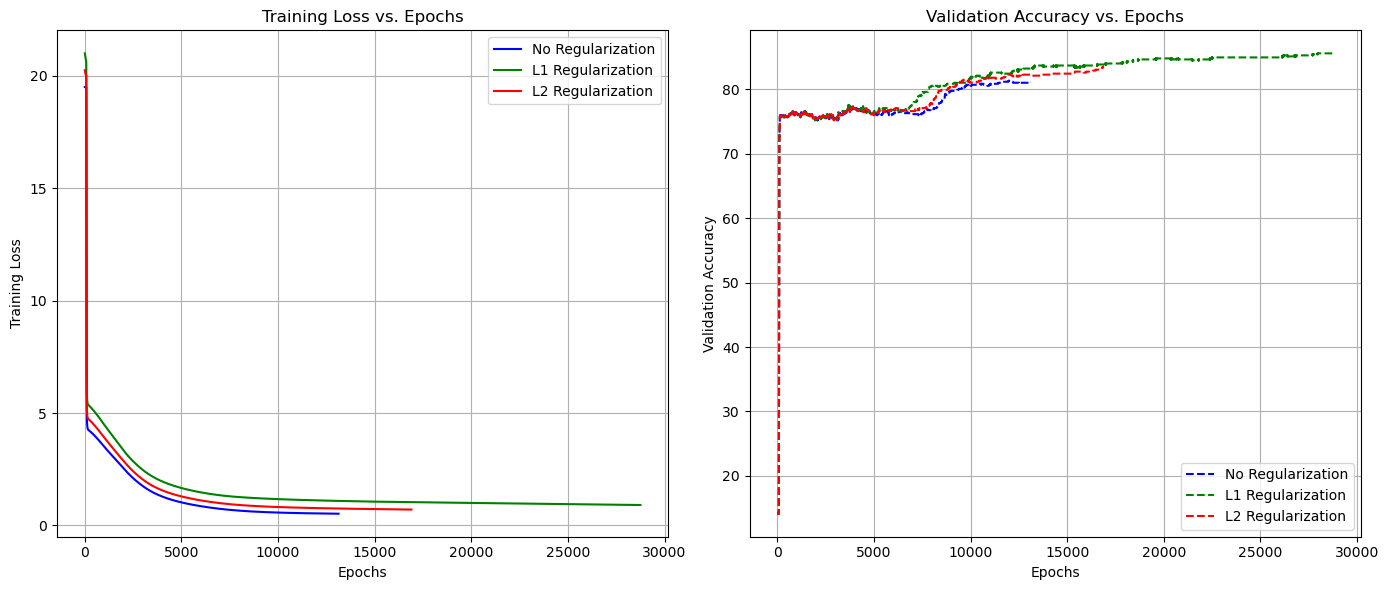

In [28]:


# Create subplots: 1 row, 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the training loss for all three models in the first subplot
ax1.plot(trainingLoss, label="No Regularization", color='blue')
ax1.plot(trainingLoss1, label="L1 Regularization", color='green')
ax1.plot(trainingLoss2, label="L2 Regularization", color='red')
ax1.set_title('Training Loss vs. Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss')
ax1.legend()
ax1.grid(True)

# Plotting the validation accuracy for all three models in the second subplot
ax2.plot(validationAcc, label="No Regularization", color='blue', linestyle='dashed')
ax2.plot(validationAcc1, label="L1 Regularization", color='green', linestyle='dashed')
ax2.plot(validationAcc2, label="L2 Regularization", color='red', linestyle='dashed')
ax2.set_title('Validation Accuracy vs. Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to make space between plots
plt.tight_layout()

# Display the plots
plt.show()


**`regularisation with no early stopping`**

In [68]:
learningRate = 0.001
epochs = 50000

In [69]:
#withoutearlyStopping
#no regularisation
model = LogisticRegression(learningRate, epochs, regularization='none')

earlyStopping = False

#training the model on training data
model.gradientDescent(X_train, Y_train, earlyStopping)
trainingLoss = model.costList

#testing the model on training data
trainingAcc = model.accuracyList

#storing predictions for the training data
modelPredictions_train = model.classify(X_train)

print("-----------####------####------####-------------")

validationLoss = model.getValCost()

#testing the model on validation data
validationAcc = model.valAccList

#storing predictions for the validation data
modelPredictions_val = model.classify(X_val)

print(f"Validation accuracy without early stopping without l1: {accuracy(modelPredictions_val, Y_val)}")

print()
print("-----------####------####------####-------------")
print("-----------####------####------####-------------")
print()
#withputearlyStopping
#l1 regularisation
model1 = LogisticRegression(learningRate, epochs, regularization='l1')

earlyStopping = False

#training the model on training data
model1.gradientDescent(X_train, Y_train, earlyStopping)
trainingLoss1 = model1.costList

#testing the model on training data
trainingAcc1 = model1.accuracyList

#storing predictions for the training data
modelPredictions_train1 = model1.classify(X_train)

print("-----------####------####------####-------------")

validationLoss1 = model1.getValCost()

#testing the model on validation data
validationAcc1 = model1.valAccList

#storing predictions for the validation data
modelPredictions_val1 = model1.classify(X_val)

print(f"Validation accuracy without early stopping with l1: {accuracy(modelPredictions_val1, Y_val)}")

print()
print("-----------####------####------####-------------")
print("-----------####------####------####-------------")
print()
#noearlyStopping
#l2 regularisation
model2 = LogisticRegression(learningRate, epochs, regularization='l2')

earlyStopping = False

#training the model on training data
model2.gradientDescent(X_train, Y_train, earlyStopping)
trainingLoss2 = model2.costList

#testing the model on training data
trainingAcc2 = model2.accuracyList

#storing predictions for the training data
modelPredictions_train2 = model2.classify(X_train)

print("-----------####------####------####-------------")

validationLoss2 = model2.getValCost()

#testing the model on validation data
validationAcc2 = model2.valAccList

#storing predictions for the validation data
modelPredictions_val2 = model2.classify(X_val)

print(f"Validation accuracy without early stopping with l2: {accuracy(modelPredictions_val2, Y_val)}")

Cost after 0 iterations: 19.493564290301745 & accuracy : 15.340525960890089
Cost after 5000 iterations: 1.2464005407948973 & accuracy : 84.72690492245448
Cost after 10000 iterations: 3.313303434027961 & accuracy : 84.65947403910991
Cost after 15000 iterations: 3.514722920756449 & accuracy : 84.65947403910991
Cost after 20000 iterations: 3.2169632807213517 & accuracy : 84.65947403910991
Cost after 25000 iterations: 3.532282386236308 & accuracy : 84.65947403910991
Cost after 30000 iterations: 1.4584090626698476 & accuracy : 85.03034389750506
Cost after 35000 iterations: 0.7674127797975759 & accuracy : 76.87120701281187
Cost after 40000 iterations: 3.4621151893372875 & accuracy : 84.65947403910991
Cost after 45000 iterations: 2.8796511372432336 & accuracy : 33.37828725556305
-----------####------####------####-------------
Validation accuracy after early stopping without l1: 85.84905660377359

-----------####------####------####-------------
-----------####------####------####------------

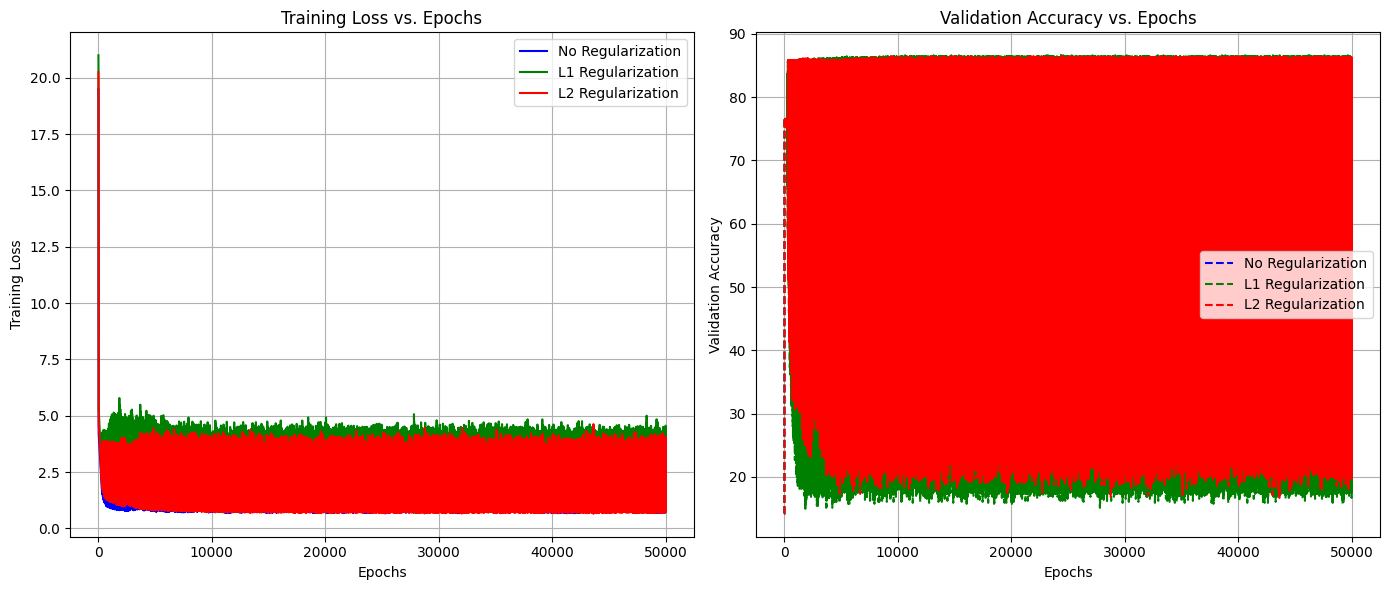

In [70]:


# Create subplots: 1 row, 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the training loss for all three models in the first subplot
ax1.plot(trainingLoss, label="No Regularization", color='blue')
ax1.plot(trainingLoss1, label="L1 Regularization", color='green')
ax1.plot(trainingLoss2, label="L2 Regularization", color='red')
ax1.set_title('Training Loss vs. Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss')
ax1.legend()
ax1.grid(True)

# Plotting the validation accuracy for all three models in the second subplot
ax2.plot(validationAcc, label="No Regularization", color='blue', linestyle='dashed')
ax2.plot(validationAcc1, label="L1 Regularization", color='green', linestyle='dashed')
ax2.plot(validationAcc2, label="L2 Regularization", color='red', linestyle='dashed')
ax2.set_title('Validation Accuracy vs. Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to make space between plots
plt.tight_layout()

# Display the plots
plt.show()
